In [3]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SolveLinSys
from numba import njit
from derivative import derivatives_2d

PDE:

\begin{align*}
0 = \max_{\tilde{e}} \min_{\pi_i^c, \sum_{i=1}^n \pi^c_i=1} & b \delta \eta \log \tilde{e} + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right] \tilde{e}  \sum_{i=1}^n \pi^a_i \theta_i\\
& + \frac{\partial V}{\partial y}\tilde{e} \sum_{i=1}^n \pi^a_i \theta_i - b \delta \frac{\partial V}{\partial b}\\
& + \frac{1}{2}\frac{\partial^2 V}{(\partial y)^2}|\sigma_y|^2(\tilde{e})^2 - \ell \tilde{e}\\
& + b(\eta-1)\left[\frac{1}{2}\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)\right]|\sigma_y|^2(\tilde{e})^2\\
&  + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
\end{align*}

The FOC of $\tilde{e}$ gives:

$$
\tilde{e}^* = \frac{-\left[ G(y)\sum_{i=1}^n \pi^c_i - \ell\right] - \sqrt{\left[ G(y)\sum_{i=1}^n \pi^c_i - \ell\right]^2-4b\delta \eta |\sigma_y|^2F(y)}}{2|\sigma_y|^2F(y)}
$$

where $G(y):=\frac{\partial V}{\partial y} + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]$, $F(y):=\frac{\partial^2 V}{(\partial y)^2} + b(\eta-1)\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)$.

In addition, the FOC of $\pi^a$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{\xi_a}G(y)\tilde{e}\theta_i\right]\hat{\pi}^a_i
$$

In [4]:
def false_transient_one_iteration(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_y.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F')])
    C = np.hstack([C_yy.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

In [9]:
def false_transient(y_grid, b_grid, ell, multiplier, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, ξ_a, σ_y, γ_1, γ_2, γ_2p, y_bar = model_paras
    Δ_y = y_grid[1] - y_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -δ*η*(y_mat+y_mat**2)

    d_Λ = γ_1 + γ_2*y_mat + γ_2p*(y_mat>y_bar)*(y_mat-y_bar)
    dd_Λ = γ_2 + γ_2p*(y_mat>y_bar)

    πc = np.ones((len(πc_o), len(y_grid), len(b_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape    

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy = derivatives_2d(v0, 0, 1, Δ_y)
        v0_dyy = derivatives_2d(v0, 0, 2, Δ_y)
        v0_db = derivatives_2d(v0, 1, 1, Δ_b)

        G = v0_dy/multiplier + b_mat*(η-1)*d_Λ
        F = v0_dyy/multiplier + b_mat*(η-1.)*dd_Λ

        if σ_y == 0:
            e_tilde = -b_mat*δ*η/(G*np.sum(πc*θ, axis=0)-ell)
        else:
            root = (np.sum(πc*θ, axis=0)*G - ell)**2 - 4*b_mat*δ*η*(σ_y**2*F)
            root[root<0] = 0.
            e_tilde = (-(G*np.sum(πc*θ, axis=0)-ell) - np.sqrt(root)) / (2*σ_y**2*F)
        e_tilde[e_tilde<=0] = 1e-16        

        log_πc_ratio = -G*e_tilde*np.sum(πc*θ, axis=0)/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)        

        A = np.zeros_like(y_mat)
        B_y = e_tilde * np.sum(πc*θ, axis=0) / multiplier
        B_b = -b_mat*δ / multiplier
        C_yy = .5 * σ_y**2 * e_tilde**2 / multiplier
        C_bb = np.zeros_like(y_mat)
        D = b_mat*δ*η*np.log(e_tilde) + b_mat*(η-1)*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*b_mat*(η-1)*dd_Λ*σ_y**2*e_tilde**2 - ell*e_tilde\
            + ξ_a * c_entropy
        res = false_transient_one_iteration(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ*multiplier) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0/multiplier,
           'v0_dy': v0_dy/multiplier,
           'v0_dyy': v0_dyy/multiplier,
           'e_tilde': e_tilde,
           'y_grid': y_grid,}
    return res

In [11]:
ξ_a = 1000.

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
# γ_2p = .0197*2*.5 # weighted model of low and high
γ_2p = 0. # low damage model

n_y = 100
y_min = 0.
y_max = 4.
y_grid = np.linspace(y_min, y_max, n_y)

n_b = 100
b_min = 1./n_b
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

model_paras = (η, δ, θ, πc_o, ξ_a, σ_y, γ_1, γ_2, γ_2p, y_bar) 

ell = 1e-7
ell_step = ell/100.
multiplier = 100.

model_res = false_transient(y_grid, b_grid, ell, multiplier, model_paras=model_paras, v0=None, ϵ=1.,
                            tol=1e-6, max_iter=1_000, print_all=True)
model_res_right = false_transient(y_grid, b_grid, ell+ell_step, multiplier, model_paras=model_paras, v0=None, ϵ=1.,
                            tol=1e-6, max_iter=1_000, print_all=False)

Iteration 1: LHS Error: 0.12069631176891296; RHS Error 0.0013288072346077067
Iteration 2: LHS Error: 0.11250193549494181; RHS Error 0.00121392083253878
Iteration 3: LHS Error: 0.10623800352160936; RHS Error 0.0011299244350997395
Iteration 4: LHS Error: 0.10116592459260532; RHS Error 0.001065505193485348
Iteration 5: LHS Error: 0.09690649156709186; RHS Error 0.0010137057391501338
Iteration 6: LHS Error: 0.09323335740630856; RHS Error 0.000970468186953387
Iteration 7: LHS Error: 0.09000038941969468; RHS Error 0.0009333371393582482
Iteration 8: LHS Error: 0.08710857709408393; RHS Error 0.0009007475495155377
Iteration 9: LHS Error: 0.08448828137413789; RHS Error 0.0008716534040830368
Iteration 10: LHS Error: 0.08208896951848677; RHS Error 0.0008453269743984793
Iteration 11: LHS Error: 0.07987297960715267; RHS Error 0.000821244602103704
Iteration 12: LHS Error: 0.07781158244260955; RHS Error 0.0007990184600915795
Iteration 13: LHS Error: 0.07588241704036536; RHS Error 0.0007783542232113003


Iteration 110: LHS Error: 0.016688413056791696; RHS Error 0.0001691191453296328
Iteration 111: LHS Error: 0.016468175518122408; RHS Error 0.00016688460929468855
Iteration 112: LHS Error: 0.016251098026679678; RHS Error 0.00016468221315564513
Iteration 113: LHS Error: 0.016037127426801412; RHS Error 0.0001625114156052342
Iteration 114: LHS Error: 0.015826212675021267; RHS Error 0.00016037169917258037
Iteration 115: LHS Error: 0.015618302451950505; RHS Error 0.00015826253562167846
Iteration 116: LHS Error: 0.015413347196268745; RHS Error 0.00015618342239905297
Iteration 117: LHS Error: 0.01521129812851818; RHS Error 0.00015413385497701137
Iteration 118: LHS Error: 0.015012107236148431; RHS Error 0.0001521133455436454
Iteration 119: LHS Error: 0.014815728272875361; RHS Error 0.00015012142549804524
Iteration 120: LHS Error: 0.014622115407377123; RHS Error 0.0001481576296740114
Iteration 121: LHS Error: 0.014431223275851224; RHS Error 0.00014622148103295043
Iteration 122: LHS Error: 0.01424

Iteration 218: LHS Error: 0.004172346023091578; RHS Error 4.2255725088591e-05
Iteration 219: LHS Error: 0.004119787750949122; RHS Error 4.1723477643451504e-05
Iteration 220: LHS Error: 0.0040678879180218175; RHS Error 4.1197898909755095e-05
Iteration 221: LHS Error: 0.004016637443902127; RHS Error 4.067889037115489e-05
Iteration 222: LHS Error: 0.003966028891793982; RHS Error 4.016639497063119e-05
Iteration 223: LHS Error: 0.003916052778215828; RHS Error 3.966029926236127e-05
Iteration 224: LHS Error: 0.0038667025304848224; RHS Error 3.916054660248181e-05
Iteration 225: LHS Error: 0.0038179691691739848; RHS Error 3.866704106557394e-05
Iteration 226: LHS Error: 0.0037698447936529433; RHS Error 3.817970173882932e-05
Iteration 227: LHS Error: 0.0037223225952889294; RHS Error 3.769846738019473e-05
Iteration 228: LHS Error: 0.0036753937529372394; RHS Error 3.7223235261436166e-05
Iteration 229: LHS Error: 0.0036290516602326406; RHS Error 3.67539562535858e-05
Iteration 230: LHS Error: 0.00358

Iteration 323: LHS Error: 0.001086505225266876; RHS Error 1.100771045368194e-05
Iteration 324: LHS Error: 0.0010724169509108705; RHS Error 1.0865050076831447e-05
Iteration 325: LHS Error: 0.001058504502690738; RHS Error 1.0724177090035169e-05
Iteration 326: LHS Error: 0.001044764762306194; RHS Error 1.0585045470509866e-05
Iteration 327: LHS Error: 0.0010311961241047385; RHS Error 1.0447643594703264e-05
Iteration 328: LHS Error: 0.0010177969334286274; RHS Error 1.0311967840449104e-05
Iteration 329: LHS Error: 0.001004564056027668; RHS Error 1.0177967022225961e-05
Iteration 330: LHS Error: 0.00099149622090966; RHS Error 1.004564088405934e-05
Iteration 331: LHS Error: 0.0009785911961603944; RHS Error 9.914962504673917e-06
Iteration 332: LHS Error: 0.0009658470423357102; RHS Error 9.7859175585387e-06
Iteration 333: LHS Error: 0.0009532612834703968; RHS Error 9.658472440717144e-06
Iteration 334: LHS Error: 0.000940832014122428; RHS Error 9.532613937685876e-06
Iteration 335: LHS Error: 0.000

Iteration 428: LHS Error: 0.0002588576664388498; RHS Error 2.626776209012577e-06
Iteration 429: LHS Error: 0.0002550853489839966; RHS Error 2.588578596097557e-06
Iteration 430: LHS Error: 0.00025136009891824074; RHS Error 2.550851867995775e-06
Iteration 431: LHS Error: 0.0002476818306771378; RHS Error 2.5136020309163244e-06
Iteration 432: LHS Error: 0.00024404964857449585; RHS Error 2.476823788566938e-06
Iteration 433: LHS Error: 0.00024046253596043954; RHS Error 2.4404966377805258e-06
Iteration 434: LHS Error: 0.0002369203758565419; RHS Error 2.40462284621342e-06
Iteration 435: LHS Error: 0.00023342309411500395; RHS Error 2.369207461791565e-06
Iteration 436: LHS Error: 0.00022996913372530514; RHS Error 2.334227538388191e-06
Iteration 437: LHS Error: 0.0002265589285919134; RHS Error 2.2996932627592512e-06
Iteration 438: LHS Error: 0.0002231912005710157; RHS Error 2.2655849935017663e-06
Iteration 439: LHS Error: 0.00021986599734713508; RHS Error 2.231912153700011e-06
Iteration 440: LHS 

Iteration 533: LHS Error: 5.529064523234796e-05; RHS Error 1.5725438471755502e-06
Iteration 534: LHS Error: 5.5194477958108584e-05; RHS Error 1.5824268030057787e-06
Iteration 535: LHS Error: 5.5098126515773505e-05; RHS Error 1.5921818933197635e-06
Iteration 536: LHS Error: 5.5001790085893246e-05; RHS Error 1.6018094792426968e-06
Iteration 537: LHS Error: 5.4905970755247946e-05; RHS Error 1.611308523007159e-06
Iteration 538: LHS Error: 5.4809110602176137e-05; RHS Error 1.6206834445143354e-06
Iteration 539: LHS Error: 5.4713344517653625e-05; RHS Error 1.6299356364817648e-06
Iteration 540: LHS Error: 5.461704053299869e-05; RHS Error 1.6390722931181089e-06
Iteration 541: LHS Error: 5.452064835260485e-05; RHS Error 1.6480801243172645e-06
Iteration 542: LHS Error: 5.442444104083316e-05; RHS Error 1.6569717224056103e-06
Iteration 543: LHS Error: 5.432810701889827e-05; RHS Error 1.6657447758364674e-06
Iteration 544: LHS Error: 5.423246619668323e-05; RHS Error 1.6744018380165406e-06
Iteration 5

Iteration 638: LHS Error: 4.5475010809109366e-05; RHS Error 2.127395400176998e-06
Iteration 639: LHS Error: 4.5385564916446304e-05; RHS Error 2.1296275550926553e-06
Iteration 640: LHS Error: 4.529669879676807e-05; RHS Error 2.1318232572431354e-06
Iteration 641: LHS Error: 4.520813935638551e-05; RHS Error 2.133987189019632e-06
Iteration 642: LHS Error: 4.511944635609243e-05; RHS Error 2.13610948399058e-06
Iteration 643: LHS Error: 4.50308666413695e-05; RHS Error 2.1382085480028132e-06
Iteration 644: LHS Error: 4.4941905792564817e-05; RHS Error 2.1402696883590774e-06
Iteration 645: LHS Error: 4.48537186021657e-05; RHS Error 2.1422998039968486e-06
Iteration 646: LHS Error: 4.476530495959837e-05; RHS Error 2.1442904636790813e-06
Iteration 647: LHS Error: 4.467717874578154e-05; RHS Error 2.1462577309052646e-06
Iteration 648: LHS Error: 4.4589167839232356e-05; RHS Error 2.1481895964701363e-06
Iteration 649: LHS Error: 4.45012080404557e-05; RHS Error 2.150093246038845e-06
Iteration 650: LHS E

Iteration 743: LHS Error: 3.674882765442772e-05; RHS Error 2.23224465474613e-06
Iteration 744: LHS Error: 3.667228966420249e-05; RHS Error 2.232434526977024e-06
Iteration 745: LHS Error: 3.659577232838123e-05; RHS Error 2.2326249004729626e-06
Iteration 746: LHS Error: 3.6518794859908475e-05; RHS Error 2.232789784774921e-06
Iteration 747: LHS Error: 3.644249424866091e-05; RHS Error 2.2329612003156455e-06
Iteration 748: LHS Error: 3.6366331118421226e-05; RHS Error 2.2331123753385577e-06
Iteration 749: LHS Error: 3.629016057951935e-05; RHS Error 2.233266954185134e-06
Iteration 750: LHS Error: 3.6214173136871284e-05; RHS Error 2.2333989661506206e-06
Iteration 751: LHS Error: 3.6138269484015356e-05; RHS Error 2.233536201706873e-06
Iteration 752: LHS Error: 3.606259098884007e-05; RHS Error 2.2336539503033364e-06
Iteration 753: LHS Error: 3.598685440227268e-05; RHS Error 2.2337737894106155e-06
Iteration 754: LHS Error: 3.591121583356051e-05; RHS Error 2.2338750494866775e-06
Iteration 755: LHS

Iteration 848: LHS Error: 2.9352001230925368e-05; RHS Error 2.2200378488992966e-06
Iteration 849: LHS Error: 2.9287467823178436e-05; RHS Error 2.219724521696463e-06
Iteration 850: LHS Error: 2.9223615129875518e-05; RHS Error 2.2194245894234348e-06
Iteration 851: LHS Error: 2.915978619181126e-05; RHS Error 2.219106457163858e-06
Iteration 852: LHS Error: 2.9096340528291485e-05; RHS Error 2.218793878153982e-06
Iteration 853: LHS Error: 2.9032719250115645e-05; RHS Error 2.2184859062176175e-06
Iteration 854: LHS Error: 2.8968830392984285e-05; RHS Error 2.2181643698945515e-06
Iteration 855: LHS Error: 2.8905948134018856e-05; RHS Error 2.21785270448666e-06
Iteration 856: LHS Error: 2.8842104634529183e-05; RHS Error 2.2175347269244106e-06
Iteration 857: LHS Error: 2.8779034424720497e-05; RHS Error 2.2172097184563555e-06
Iteration 858: LHS Error: 2.871594808444202e-05; RHS Error 2.216892944264734e-06
Iteration 859: LHS Error: 2.8652969115470703e-05; RHS Error 2.216562741719848e-06
Iteration 860

Iteration 953: LHS Error: 2.3237144067917923e-05; RHS Error 2.1820186923900706e-06
Iteration 954: LHS Error: 2.318438018742309e-05; RHS Error 2.1816416064809148e-06
Iteration 955: LHS Error: 2.3132283559756765e-05; RHS Error 2.1812556391825368e-06
Iteration 956: LHS Error: 2.3079641062831793e-05; RHS Error 2.1808650032808727e-06
Iteration 957: LHS Error: 2.302771454547499e-05; RHS Error 2.1804864889195252e-06
Iteration 958: LHS Error: 2.297588824349585e-05; RHS Error 2.1800940067520994e-06
Iteration 959: LHS Error: 2.2923596339114588e-05; RHS Error 2.1797150519816495e-06
Iteration 960: LHS Error: 2.2872007105365078e-05; RHS Error 2.179324017709521e-06
Iteration 961: LHS Error: 2.2820288931076765e-05; RHS Error 2.178944180314369e-06
Iteration 962: LHS Error: 2.276813392515769e-05; RHS Error 2.17855235492637e-06
Iteration 963: LHS Error: 2.2716878512989667e-05; RHS Error 2.178173508381523e-06
Iteration 964: LHS Error: 2.266561452087413e-05; RHS Error 2.1777818847367684e-06
Iteration 965:

In [14]:
ψ_ell = model_res['v0'][:, -1]
ψ_ell_right = model_res_right['v0'][:, -1]
dψ_ell = (ψ_ell_right-ψ_ell)/ell_step
r = -dψ_ell

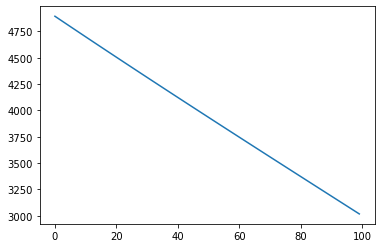

In [15]:
plt.plot(r)